# Semi-Supervised Training

This notebook trains the sentiment classifier on a combined dataset of hard labels (ground truth) and weak labels (generated by k-NN).

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from data_loader import load_and_split_data
from models import SentimentClassifier
from weak_labeling import WeakLabeler

## Load Data

In [2]:
splits = load_and_split_data()
test_df = splits['test']
val_df = splits['val']

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'takala/financial_phrasebank' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading dataset: takala/financial_phrasebank (sentences_allagree)


Using the latest cached version of the dataset since takala/financial_phrasebank couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'sentences_allagree' at /Users/stefanbinkert/.cache/huggingface/datasets/takala___financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141 (last modified on Tue Nov 25 21:04:35 2025).


Total samples: 2264
Test size: 453
Validation size: 182
Training pool size: 1629
Created split 'train_100': 100 samples
Created split 'unlabeled_100': 1529 samples
Created split 'train_250': 250 samples
Created split 'unlabeled_250': 1379 samples
Created split 'train_500': 500 samples
Created split 'unlabeled_500': 1129 samples
Created split 'train_1000': 1000 samples
Created split 'unlabeled_1000': 629 samples


## Initialize Weak Labeler

In [3]:
labeler = WeakLabeler(model_name="all-mpnet-base-v2")

## Train Semi-Supervised Models

For each split size:
1. Train k-NN on labeled data.
2. Generate weak labels for unlabeled data.
3. Combine labeled and weak-labeled data.
4. Train classifier on combined data.
5. Evaluate.

In [4]:
train_sizes = [100, 250, 500, 1000]
results = []

for size in train_sizes:
    print(f"\n=== Semi-Supervised Training for {size} labeled samples ===")
    train_df = splits[f'train_{size}']
    unlabeled_df = splits[f'unlabeled_{size}']
    
    # 1. Train k-NN
    knn = labeler.train_knn(train_df, n_neighbors=5)
    
    # 2. Generate Weak Labels
    weak_labeled_df = labeler.predict(knn, unlabeled_df)
    
    # 3. Combine Data
    # We can add a flag to distinguish source if needed, but for training we just need sentence and label
    combined_df = pd.concat([train_df, weak_labeled_df[['sentence', 'label']]]).reset_index(drop=True)
    print(f"Combined training set size: {len(combined_df)}")
    
    # 4. Train Classifier
    classifier = SentimentClassifier(model_name="distilbert-base-uncased", output_dir=f"../models/semi_supervised_{size}")
    classifier.train(combined_df, val_df, epochs=3, batch_size=16)
    
    # 5. Evaluate
    metrics = classifier.evaluate(test_df)
    print(f"Results for {size} (Semi-Supervised): {metrics}")
    
    results.append({
        'train_size': size,
        'accuracy': metrics['eval_accuracy'],
        'f1': metrics['eval_f1']
    })


=== Semi-Supervised Training for 100 labeled samples ===


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Combined training set size: 1629


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1629 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.450900,0.387428,0.884615,0.848580,0.851589,0.869177
2,0.264300,0.359558,0.884615,0.844946,0.846687,0.869177
3,0.175500,0.363773,0.884615,0.846808,0.842146,0.873447


/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Map:   0%|          | 0/453 [00:00<?, ? examples/s]

/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


wandb: Currently logged in as: steff72 (steff72-fachhochschule-nordwestschweiz-fhnw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid u

Results for 100 (Semi-Supervised): {'eval_loss': 0.44331252574920654, 'eval_model_preparation_time': 0.0005, 'eval_accuracy': 0.8763796909492274, 'eval_f1': 0.8441591017677975, 'eval_precision': 0.8377544441374228, 'eval_recall': 0.8630407149690084, 'eval_runtime': 6.288, 'eval_samples_per_second': 72.042, 'eval_steps_per_second': 9.065}

=== Semi-Supervised Training for 250 labeled samples ===


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Combined training set size: 1629


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1629 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.422600,0.301474,0.912088,0.884441,0.904564,0.888328
2,0.249100,0.224179,0.912088,0.881804,0.891127,0.892598
3,0.174100,0.232125,0.912088,0.881804,0.891127,0.892598


/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Map:   0%|          | 0/453 [00:00<?, ? examples/s]

/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for 250 (Semi-Supervised): {'eval_loss': 0.3339709937572479, 'eval_model_preparation_time': 0.0005, 'eval_accuracy': 0.8984547461368654, 'eval_f1': 0.8583314945572228, 'eval_precision': 0.868035598405488, 'eval_recall': 0.8563382253644883, 'eval_runtime': 5.5345, 'eval_samples_per_second': 81.85, 'eval_steps_per_second': 10.299}

=== Semi-Supervised Training for 500 labeled samples ===


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

Combined training set size: 1629


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1629 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.376300,0.268700,0.923077,0.893607,0.901409,0.887164
2,0.216200,0.199030,0.939560,0.916567,0.913739,0.928830
3,0.198300,0.175505,0.950549,0.932218,0.929433,0.936680


/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Map:   0%|          | 0/453 [00:00<?, ? examples/s]

/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for 500 (Semi-Supervised): {'eval_loss': 0.20802170038223267, 'eval_model_preparation_time': 0.0005, 'eval_accuracy': 0.9205298013245033, 'eval_f1': 0.9055924022501562, 'eval_precision': 0.9104472284684298, 'eval_recall': 0.9010086150234256, 'eval_runtime': 5.6848, 'eval_samples_per_second': 79.687, 'eval_steps_per_second': 10.027}

=== Semi-Supervised Training for 1000 labeled samples ===


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Combined training set size: 1629


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1629 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.345600,0.222615,0.934066,0.914120,0.924221,0.910671
2,0.147600,0.126180,0.961538,0.942137,0.944100,0.940261
3,0.136200,0.119245,0.961538,0.942137,0.944100,0.940261


/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Map:   0%|          | 0/453 [00:00<?, ? examples/s]

/Users/stefanbinkert/Documents/FHNW_DS/NPR/NPR_MC_2/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for 1000 (Semi-Supervised): {'eval_loss': 0.19274389743804932, 'eval_model_preparation_time': 0.0005, 'eval_accuracy': 0.9337748344370861, 'eval_f1': 0.9103052701987172, 'eval_precision': 0.9078117320899755, 'eval_recall': 0.9143808335557612, 'eval_runtime': 5.7876, 'eval_samples_per_second': 78.27, 'eval_steps_per_second': 9.849}


## Plot Comparison (Baseline vs Semi-Supervised)

Note: You should manually input the baseline results here or load them from a saved file for comparison.

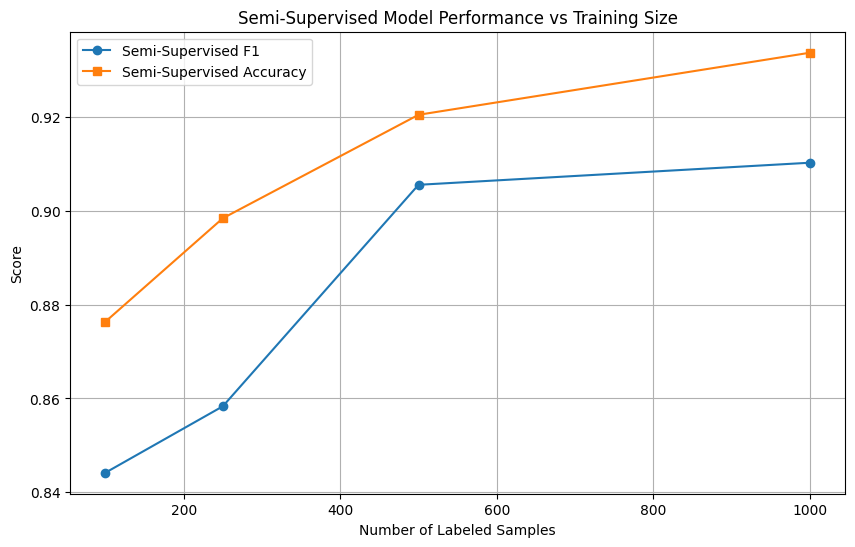

In [5]:
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['train_size'], results_df['f1'], marker='o', label='Semi-Supervised F1')
plt.plot(results_df['train_size'], results_df['accuracy'], marker='s', label='Semi-Supervised Accuracy')
plt.title('Semi-Supervised Model Performance vs Training Size')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()